# Image Colorization Using Deep Learning

# Set-Up

In [0]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model
from tensorflow.keras.models import load_model
from tensorflow.keras.applications.vgg16 import *

import cv2
from google.colab.patches import cv2_imshow

tf.random.set_seed(42) 
np.random.seed(42)

# Data Preparation

## Key Variables

In [0]:
IMG_SIZE     = [224, 224]
N_CHANNELS   = 3
N_CLASSES = 169
DATA_DIR     = "/content/drive/My Drive/sample_data/"

## Loading Data

In [0]:
x_train = np.load(file=DATA_DIR+"x_train.npy", allow_pickle=True)
y_train = np.load(file= DATA_DIR+"y_train.npy", allow_pickle=True)

x_test = np.load(file=DATA_DIR+"x_test.npy", allow_pickle=True)
y_test = np.load(file=DATA_DIR+"y_test.npy", allow_pickle=True)

y_train = tf.keras.utils.to_categorical(y=y_train, num_classes=N_CLASSES)
y_test = tf.keras.utils.to_categorical(y=y_test, num_classes=N_CLASSES)

# Model Architecture

## Model Building

In [0]:
def FCN8(image_size, ch_in, ch_out):

    inputs = Input(shape=(*image_size, ch_in), name='input')

    # Building a pre-trained VGG-16 as a feature extractor
    vgg16 = VGG16(include_top=False, weights='imagenet', input_tensor=inputs)

    # Feature maps of final 3 blocks:
    f3 = vgg16.get_layer('block3_pool').output  # shape: (28, 28, 256)
    f4 = vgg16.get_layer('block4_pool').output  # shape: (14, 14, 512)
    f5 = vgg16.get_layer('block5_pool').output  # shape: ( 7,  7, 512)

    f5conv1 = Conv2D(filters=4086, kernel_size=7, padding='same', 
                     activation='relu')(f5)
    f5drop1 = Dropout(0.5)(f5conv1)
    f5conv2 = Conv2D(filters=4086, kernel_size=1, padding='same', 
                     activation='relu')(f5drop1)
    f5drop2 = Dropout(0.5)(f5conv2)
    f5conv3 = Conv2D(filters=ch_out, kernel_size=1, padding='same', 
                     activation=None)(f5drop2)

    # Upscale f5 into a 14x14 feature map
    f5conv3x2 = Conv2DTranspose(filters=ch_out, kernel_size=4, strides=2, 
                                use_bias=False, padding='same', 
                                activation='relu')(f5)
    f4conv1 = Conv2D(filters=ch_out, kernel_size=1, padding='same', 
                     activation=None)(f4)
    m1 = add([f4conv1, f5conv3x2])

    m1x2 = Conv2DTranspose(filters=ch_out, kernel_size=4, strides=2, 
                           use_bias=False, padding='same', 
                           activation='relu')(m1)
    f3conv1 = Conv2D(filters=ch_out, kernel_size=1, padding='same', 
                     activation=None)(f3)
    m2 = add([f3conv1, m1x2])

    # Upscale the feature map to the original shape of 224x224
    outputs = Conv2DTranspose(filters=ch_out, kernel_size=16, strides=8, 
                              padding='same', activation='softmax')(m2)
    
    model = Model(inputs, outputs)
    return model

## Model Instantiation and summary

In [5]:
model = FCN8(IMG_SIZE, N_CHANNELS, N_CLASSES)
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 224, 224, 64) 1792        input[0][0]                      
__________________________________________________________________________________________________
block1_conv2 (Conv2D)           (None, 224, 224, 64) 36928       block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_pool (MaxPooling2D)      (None, 112, 112, 64) 0           block1_conv2[0][0]               
______________________________________________________________________________________________

# Training Preparation 

## Metrics and Loss

**Metrices:** Accuracy and IoU


**Loss:** cross-entropy vs. Dice

In [0]:
accuracy = tf.metrics.Accuracy(name='acc')
meanIoU  = tf.metrics.MeanIoU(num_classes=N_CLASSES, name='mIoU')
loss_c = tf.keras.losses.CategoricalCrossentropy()

Since we are doing multi-class classification task (pixel-level classification), we can use **cross-entropy loss**. However, to prevent the model from developing bias towards larger classes, **dice loss function** will be used because it is not affected by class proportions.

In [0]:
# TODO: Dice loss

@tf.function
def dice_loss(y_true, y_pred, eps=1e-6, spatial_axes=[1, 2], from_logits=False):
    """
    Compute the Dice loss for semantic segmentation
    :param y_true:        Ground-truth label map(s) (e.g., of shape B x H x W)
    :param y_pred:        Predicted logit map(s) () (e.g., of shape B x H x W x N, N number of classes)
    :param eps:           Epsilon small value (smooth) 
    :param spatial_axes:  Spatial axes
    :param from_logits:   Flag if predictions are logits (not normalized)
    :return:              Loss value
    """
    num_classes = y_pred.shape[-1]
        
    # Transform logits in probabilities, and one-hot the ground-truth:
    
    # Compute Dice numerator and denominator:
    num_perclass = 2 * tf.reduce_sum(y_pred * y_true, axis=spatial_axes)
    den_perclass = tf.reduce_sum(y_pred + y_true, axis=spatial_axes)

    # Compute Dice and average over batch and classes:
    dice = tf.reduce_mean((num_perclass + eps) / (den_perclass + eps))

    return 1 - dice


class DiceLoss(tf.losses.Loss):
    def __init__(self, eps=1e-6, spatial_axes=[1, 2], from_logits=False, 
                 name='loss'):
        """
        Initialize the loss.
        :param eps:           Epsilon small value (smooth) 
        :param spatial_axes:  Spatial axes
        :param from_logits:   Flag if predictions are logits (not normalized)
        :param name:          Name
        """
        super().__init__(name=name)
        self.eps = eps
        self.spatial_axes = spatial_axes
        self.from_logits = from_logits
    
    def __call__(self, y_true, y_pred, sample_weight=None):
        """
        Compute the Dice loss for semantic segmentation, ignoring pixels from some misc. classes.
        :param y_true:        Ground-truth label map(s) (e.g., of shape B x H x W)
        :param y_pred:        Predicted logit map(s) () (e.g., of shape B x H x W x N, N number of classes)
        :param sample_weight: opt. weight tensor, broadcastable to `y_true`
        :return:              Loss value
        """
        return dice_loss(y_true, y_pred, eps=self.eps, 
                         spatial_axes=self.spatial_axes, from_logits=self.from_logits)

In [0]:
loss_d = DiceLoss()

## Optimizer and Callbacks

In [0]:
optimizer = tf.keras.optimizers.Adam()
callbacks = [tf.keras.callbacks.ModelCheckpoint(DATA_DIR+'fcn8.hdf5')]

## Hyper Parameters

In [0]:
BATCH_SIZE     = 8
NUM_EPOCHS     = 20

## Helper Functions

# Training

In [11]:
model.compile(optimizer=optimizer, loss=loss_d, metrics=[accuracy, meanIoU])
history = model.fit(x=x_train, y=y_train, batch_size=BATCH_SIZE, 
                    epochs=NUM_EPOCHS, validation_split=0.1765)
                    #callbacks=callbacks)

Epoch 1/20
9/9 [==============================] - 8s 862ms/step - loss: 0.5000 - acc: 0.9751 - mIoU: 0.5405 - val_loss: 0.2522 - val_acc: 0.9908 - val_mIoU: 0.5573
Epoch 2/20
9/9 [==============================] - 6s 658ms/step - loss: 0.2189 - acc: 0.9908 - mIoU: 0.5578 - val_loss: 0.2234 - val_acc: 0.9907 - val_mIoU: 0.5562
Epoch 3/20
9/9 [==============================] - 6s 671ms/step - loss: 0.2161 - acc: 0.9908 - mIoU: 0.5569 - val_loss: 0.2411 - val_acc: 0.9907 - val_mIoU: 0.5553
Epoch 4/20
9/9 [==============================] - 6s 672ms/step - loss: 0.2400 - acc: 0.9907 - mIoU: 0.5561 - val_loss: 0.2523 - val_acc: 0.9907 - val_mIoU: 0.5551
Epoch 5/20
9/9 [==============================] - 6s 669ms/step - loss: 0.2351 - acc: 0.9907 - mIoU: 0.5563 - val_loss: 0.2463 - val_acc: 0.9907 - val_mIoU: 0.5549
Epoch 6/20
9/9 [==============================] - 6s 664ms/step - loss: 0.2319 - acc: 0.9907 - mIoU: 0.5560 - val_loss: 0.2471 - val_acc: 0.9907 - val_mIoU: 0.5551
Epoch 7/20
9/9 [

In [0]:
# Save the entire model to a HDF5 file.
# The '.h5' extension indicates that the model should be saved to HDF5.
model.save(DATA_DIR+'fcn8model.h5') 

## Graphs

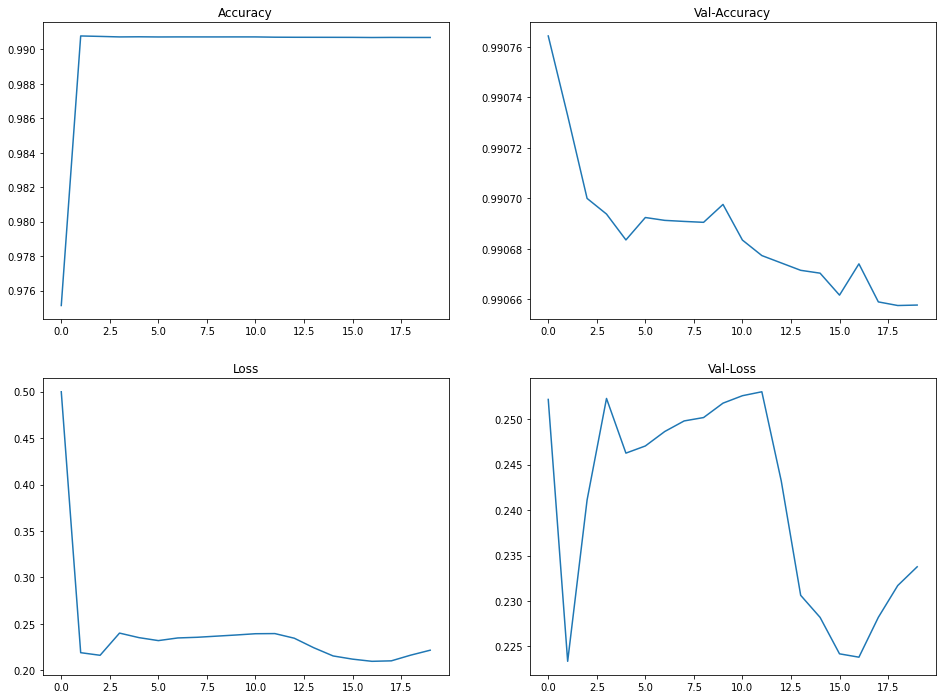

In [13]:
fig, ax = plt.subplots(2, 2, figsize=(16, 12))
ax[0, 0].set_title("Accuracy")
ax[0, 1].set_title("Val-Accuracy")
ax[1, 0].set_title("Loss")
ax[1, 1].set_title("Val-Loss")

ax[0, 0].plot(history.history['acc'])
ax[0, 1].plot(history.history['val_acc'])
ax[1, 0].plot(history.history['loss'])
ax[1, 1].plot(history.history['val_loss'])

# Testing

In [14]:
history_test = model.evaluate(x=x_test, y=y_test)

1/1 [==============================] - 0s 1ms/step - loss: 0.2327 - acc: 0.9908 - mIoU: 0.5583


# Prediction

In [0]:
#loaded_model = load_model(DATA_DIR+'fcn8model.h5')

In [0]:
def predict(images, model):
  x = images
  y_pred = np.argmax(model.predict(x), axis=-1)

  return x, y_pred

x,y_pred = predict(x_test, model) #TODO: Decide on loaded or other model

np.save(DATA_DIR+"x_pred.npy", x)
np.save(DATA_DIR+"y_pred.npy", y_pred)

# Post-process Images

In [0]:
# Create Color Array
# min = 0, max = 250, interval = 20 
def create_color_array(min, max, interval):
  ab_color_list = []

  for i in range(min, max, interval):
    for j in range(min, max, interval):
      ab_color_list.append([i, j])
      j += interval
    i += interval
  
  return ab_color_list

def convert_numpy_target_array(color_array, target_numpy_array):
  target_list = target_numpy_array.tolist()
  a_list = []
  b_list = []

  for i in range(0, len(target_list)):
    new_a_list_row = []
    new_b_list_row = []
    for j in range(0, len(target_list[i])):
      a = color_array[target_list[i][j]][0]
      b = color_array[target_list[i][j]][1]
      new_a_list_row.append(a)
      new_b_list_row.append(b)
    a_list.append(new_a_list_row)
    b_list.append(new_b_list_row)
    
    # L, a, b require specific data types 'dtype=uint8'
    a_list_numpy_array = np.array(a_list, dtype=np.uint8)
    b_list_numpy_array = np.array(b_list, dtype=np.uint8)

  return (a_list_numpy_array, b_list_numpy_array)

def post_process_image(x, y_pred, ab_color_list, index):
  L = cv2.cvtColor(x, cv2.COLOR_RGB2GRAY)
  a, b = convert_numpy_target_array(ab_color_list, y_pred)
  merged_image = cv2.merge((L, a, b))
  image_bgr = cv2.cvtColor(merged_image, cv2.COLOR_LAB2BGR)
  cv2.imwrite(DATA_DIR+str(index)+'.jpg', image_bgr)


In [0]:
x = np.load("/content/drive/My Drive/sample_10/x_pred.npy", allow_pickle=True)
y_pred = np.load("/content/drive/My Drive/sample_10/y_pred.npy", allow_pickle=True)

ab_color_list = create_color_array(0, 260, 20)

for i in range(len(x)):
  post_process_image(x[i], y_pred[i], ab_color_list,  i)

# Misc.

In [0]:
gpu = tf.test.is_gpu_available(
    cuda_only=False, min_cuda_compute_capability=None
)

print(gpu)

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.
True
